# Análisis Exploratorio de Datos (EDA)

Este notebook realiza un análisis exploratorio completo de nuestro conjunto de datos. Examinaremos las características básicas del dataset, la distribución de la variable objetivo, las relaciones entre variables numéricas y categóricas, y realizaremos visualizaciones para mejor comprensión de los datos.

## 1. Importación de Librerías

Comenzamos importando las bibliotecas necesarias para nuestro análisis. Utilizaremos pandas para manipulación de datos, numpy para operaciones numéricas, y matplotlib junto con seaborn para visualizaciones.

In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualizaciones más atractivas
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [47]:
# Configuración de rutas
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  # Subir dos niveles desde notebooks
data_dir = os.path.join(project_root, "data")
raw_data_dir = os.path.join(data_dir, "raw")
processed_data_dir = os.path.join(data_dir, "processed")

# Crear directorios si no existen
os.makedirs(raw_data_dir, exist_ok=True)
os.makedirs(processed_data_dir, exist_ok=True)

try:
    # Intentar cargar desde el archivo raw
    raw_data_path = os.path.join(raw_data_dir, "raw_data.csv")
    df = pd.read_csv(raw_data_path)
    print(f"Datos cargados exitosamente desde: {raw_data_path}")
except FileNotFoundError:
    print("Error: No se encontró el archivo de datos en la ruta especificada.")
    print(f"Ruta buscada: {raw_data_path}")

Datos cargados exitosamente desde: /Users/pepe/Documents/IA_FactoriaF5/Multiclass_Clasification/data/raw/raw_data.csv


## 2. Carga y Análisis Básico de Datos

En esta sección, cargaremos nuestro dataset y realizaremos un análisis básico para entender su estructura, dimensiones y características generales. Examinaremos la presencia de valores nulos y obtendremos estadísticas descriptivas básicas.

In [48]:
# Cargar los datos
df = pd.read_csv(raw_data_path)

def analisis_basico(df):
    print("Dimensiones del dataset:", df.shape)
    print("Información del dataset:")
    print(df.info())
    print("Estadísticas descriptivas:")
    print(df.describe())
    print("Valores nulos por columna:")
    print(df.isnull().sum())

analisis_basico(df)

Dimensiones del dataset: (4424, 35)
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   marital_status                                  4424 non-null   object 
 1   application_mode                                4424 non-null   object 
 2   application_order                               4424 non-null   int64  
 3   course                                          4424 non-null   object 
 4   attendance                                      4424 non-null   object 
 5   previous_qualification                          4424 non-null   object 
 6   nationality                                     4424 non-null   object 
 7   mother's_qualification                          4424 non-null   object 
 8   father's_qualification                          4424 non-

## 3. Limpieza de Datos
En esta sección realizamos la limpieza inicial de los datos, tratando valores nulos y anomalías

In [49]:
def limpiar_datos(df):
    # Crear una copia para no modificar los datos originales
    df_clean = df.copy()
    
    # Identificar columnas numéricas y categóricas
    columnas_numericas = df_clean.select_dtypes(include=['float64', 'int64']).columns
    columnas_categoricas = df_clean.select_dtypes(include=['object']).columns
    
    # Tratar valores nulos en columnas numéricas
    imputer_num = SimpleImputer(strategy='median')
    df_clean[columnas_numericas] = imputer_num.fit_transform(df_clean[columnas_numericas])
    
    # Tratar valores nulos en columnas categóricas
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df_clean[columnas_categoricas] = imputer_cat.fit_transform(df_clean[columnas_categoricas])
    
    return df_clean

# Aplicar limpieza
df_limpio = limpiar_datos(df)

# Verificar que no hay valores nulos
print("Valores nulos después de la limpieza:")
display(df_limpio.isnull().sum())

Valores nulos después de la limpieza:


marital_status                                    0
application_mode                                  0
application_order                                 0
course                                            0
attendance                                        0
previous_qualification                            0
nationality                                       0
mother's_qualification                            0
father's_qualification                            0
mother's_occupation                               0
father's_occupation                               0
displaced                                         0
educational_special_needs                         0
debtor                                            0
tuition_fees_up_to_date                           0
gender                                            0
scholarship_holder                                0
age_at_enrollment                                 0
international                                     0
curricular_u

## 4. Preprocesamiento de Datos
Aquí realizamos las transformaciones necesarias para preparar los datos para el análisis.

In [50]:
def preprocesar_datos(df):
    """
    Realiza el preprocesamiento de datos incluyendo:
    - Codificación de variables categóricas
    - Normalización de variables numéricas
    - Manejo del target
    """
    df_proc = df.copy()
    
    # Codificación del target
    target_mapping = {
        'Dropout': 0,
        'Graduate': 1,
        'Enrolled': 2
    }
    df_proc['target'] = df_proc['target'].map(target_mapping)
    
    # Separar características numéricas y categóricas
    numericas = df_proc.select_dtypes(include=['float64', 'int64']).columns
    numericas = numericas.drop('target') if 'target' in numericas else numericas
    categoricas = df_proc.select_dtypes(include=['object']).columns
    
    # Imprimir información sobre las variables
    print("Variables numéricas:", len(numericas))
    print(numericas.tolist())
    print("\nVariables categóricas:", len(categoricas))
    print(categoricas.tolist())
    
    # Normalizar variables numéricas
    scaler = StandardScaler()
    df_proc[numericas] = scaler.fit_transform(df_proc[numericas])
    
    # Codificar variables categóricas
    df_proc = pd.get_dummies(df_proc, columns=categoricas, drop_first=True)
    
    # Mostrar información del preprocesamiento
    print("\nDimensiones del dataset procesado:", df_proc.shape)
    print("\nDistribución de clases:")
    distribucion = df_proc['target'].value_counts().sort_index()
    for clase, count in distribucion.items():
        porcentaje = (count/len(df_proc))*100
        print(f"Clase {clase}: {count} ejemplos ({porcentaje:.2f}%)")
    
    # Verificar valores faltantes
    nulos = df_proc.isnull().sum()
    if nulos.any():
        print("\nValores faltantes encontrados:")
        print(nulos[nulos > 0])
    else:
        print("\nNo hay valores faltantes en el dataset")
    
    return df_proc

# Aplicar preprocesamiento
df_procesado = preprocesar_datos(df)

# Guardar dataset procesado
processed_data_path = os.path.join(processed_data_dir, "dataset_procesado.csv")
df_procesado.to_csv(processed_data_path, index=False)
print(f"\nDataset procesado guardado en: {processed_data_path}")

Variables numéricas: 18
['application_order', 'age_at_enrollment', 'international', 'curricular_units_1st_sem_(credited)', 'curricular_units_1st_sem_(enrolled)', 'curricular_units_1st_sem_(evaluations)', 'curricular_units_1st_sem_(approved)', 'curricular_units_1st_sem_(grade)', 'curricular_units_1st_sem_(without_evaluations)', 'curricular_units_2nd_sem_(credited)', 'curricular_units_2nd_sem_(enrolled)', 'curricular_units_2nd_sem_(evaluations)', 'curricular_units_2nd_sem_(approved)', 'curricular_units_2nd_sem_(grade)', 'curricular_units_2nd_sem_(without_evaluations)', 'unemployment_rate', 'inflation_rate', 'gdp']

Variables categóricas: 16
['marital_status', 'application_mode', 'course', 'attendance', 'previous_qualification', 'nationality', "mother's_qualification", "father's_qualification", "mother's_occupation", "father's_occupation", 'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder']

Dimensiones del dataset procesado: (442

## 5. Análisis de la Variable Objetivo

Analizaremos la distribución de nuestra variable objetivo (Target). Es crucial entender si las clases están balanceadas o si existe un desequilibrio que debamos considerar en nuestro modelo.

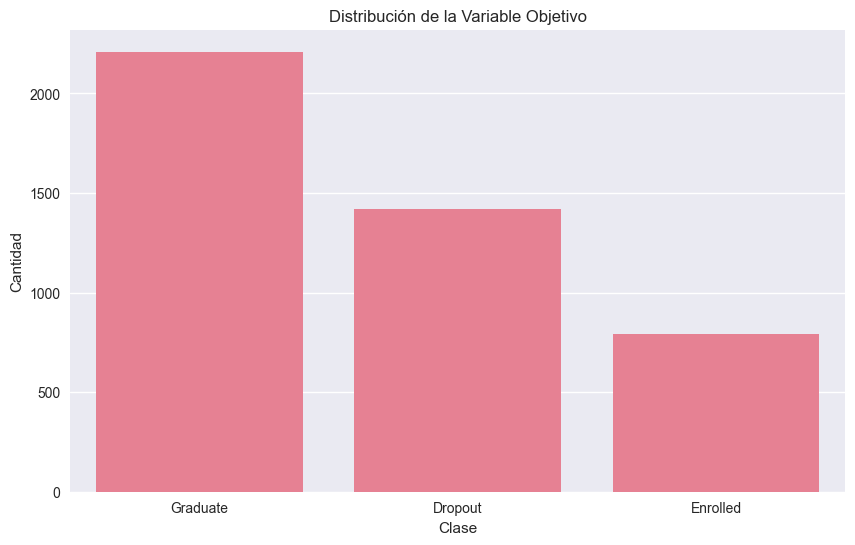

Porcentaje de cada clase:
target
Graduate    49.93%
Dropout     32.12%
Enrolled    17.95%
Name: proportion, dtype: object


In [51]:
def analisis_target(df):
    plt.figure(figsize=(10, 6))
    target_counts = df['target'].value_counts()
    sns.barplot(x=target_counts.index, y=target_counts.values)
    plt.title('Distribución de la Variable Objetivo')
    plt.xlabel('Clase')
    plt.ylabel('Cantidad')
    plt.show()

analisis_target(df)

# Mostrar porcentajes de cada clase
print("Porcentaje de cada clase:")
print(df['target'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

## 6. Análisis de Variables Numéricas

Examinaremos la distribución de nuestras variables numéricas mediante histogramas y analizaremos las correlaciones entre ellas. Esto nos ayudará a identificar patrones y relaciones importantes en los datos.

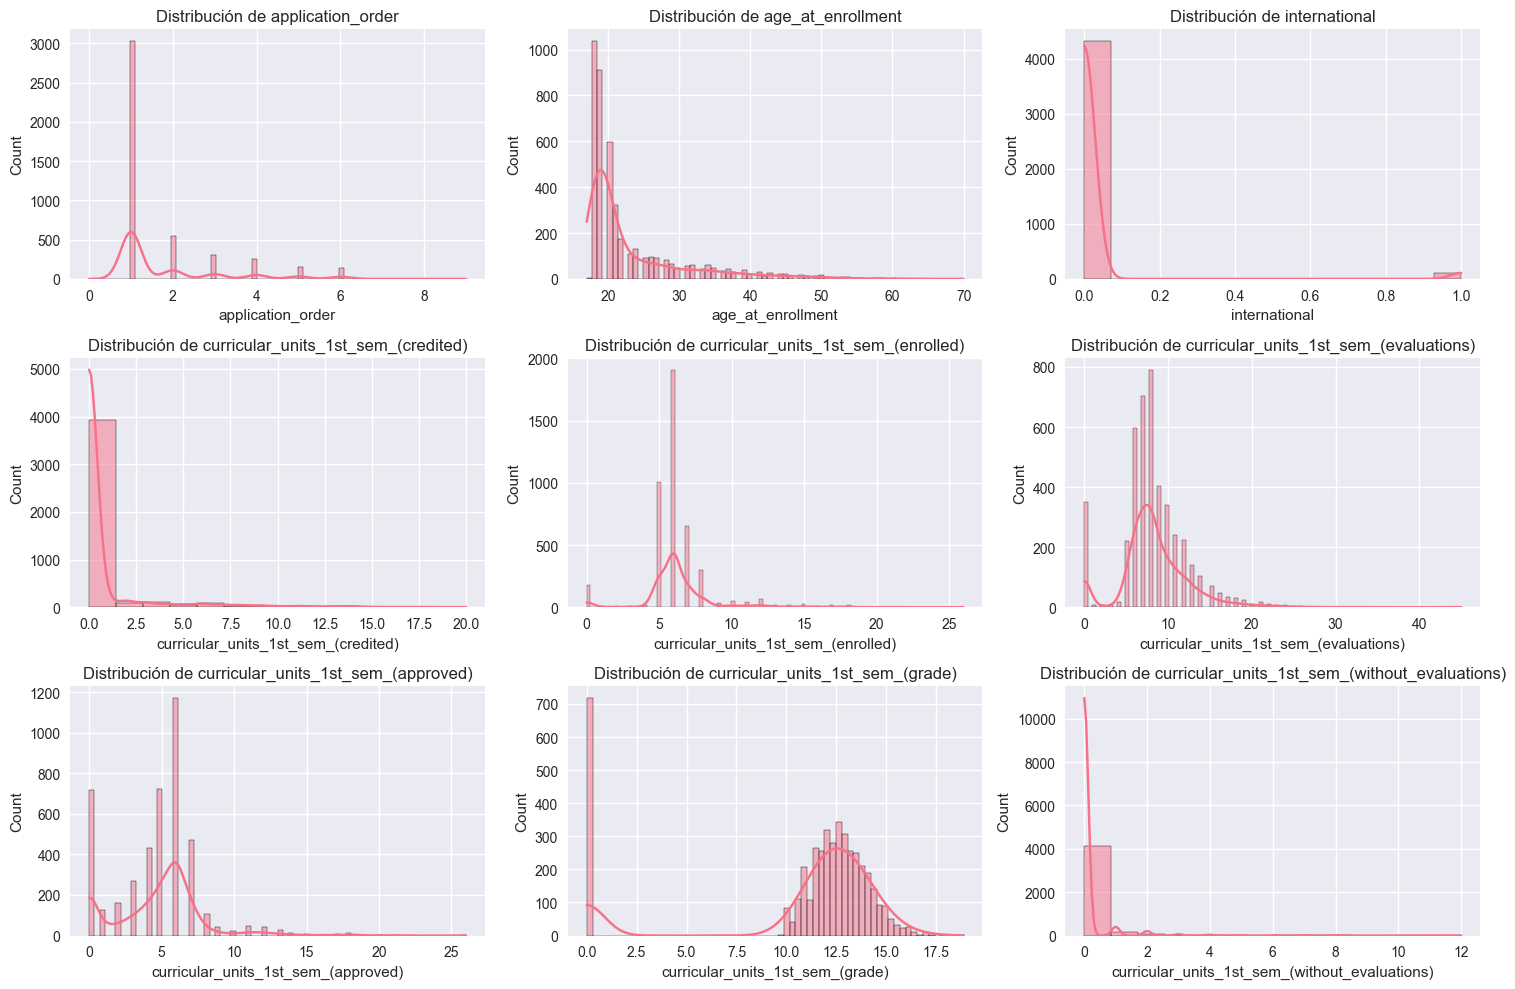

In [52]:
def analisis_numericas(df):
    numericas = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Histogramas
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numericas[:9], 1):
        plt.subplot(3, 3, i)
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribución de {col}')
    plt.tight_layout()
    plt.show()

analisis_numericas(df)

## 7. Análisis de Variables Categóricas

Para las variables categóricas, analizaremos su distribución y frecuencia. Esto nos ayudará a identificar categorías dominantes y posibles valores atípicos.

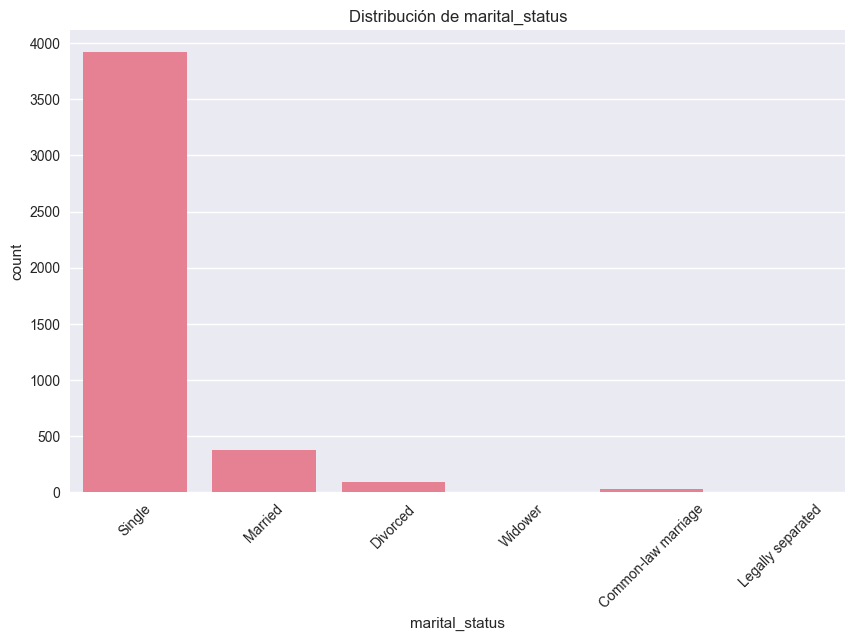

Distribución de marital_status:
                     count Porcentaje
marital_status                       
Single                3919     88.58%
Married                379      8.57%
Divorced                91      2.06%
Common-law marriage     25      0.57%
Legally separated        6      0.14%
Widower                  4      0.09%


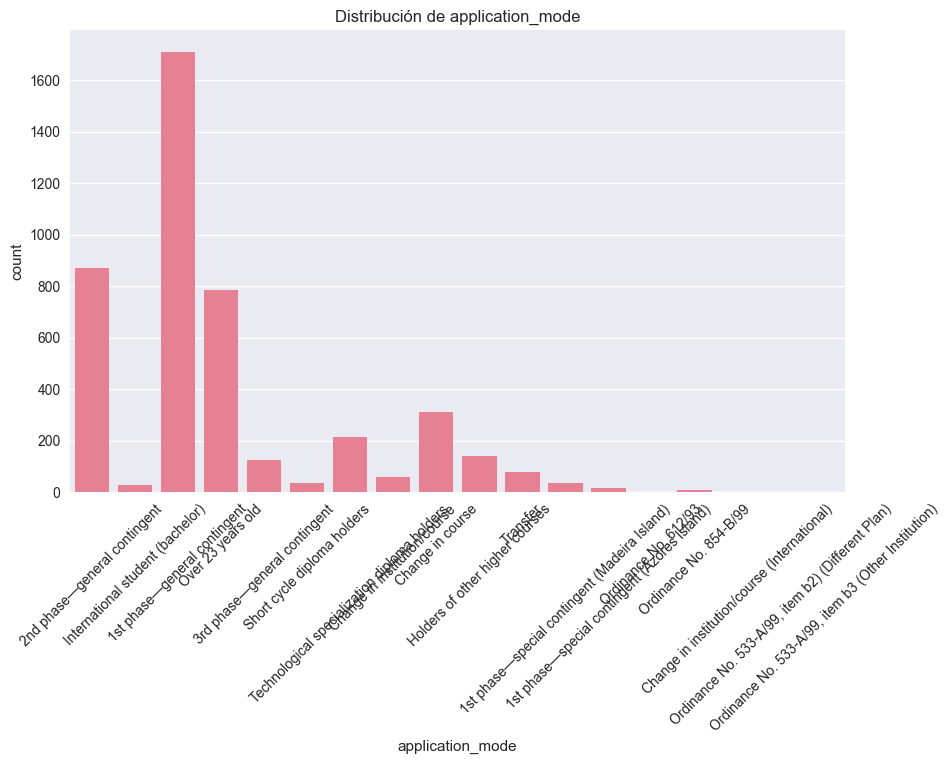

Distribución de application_mode:
                                                    count Porcentaje
application_mode                                                    
1st phase—general contingent                         1708     38.61%
2nd phase—general contingent                          872     19.71%
Over 23 years old                                     785     17.74%
Change in course                                      312      7.05%
Technological specialization diploma holders          213      4.81%
Holders of other higher courses                       139      3.14%
3rd phase—general contingent                          124       2.8%
Transfer                                               77      1.74%
Change in institution/course                           59      1.33%
1st phase—special contingent (Madeira Island)          38      0.86%
Short cycle diploma holders                            35      0.79%
International student (bachelor)                       30      0.68%


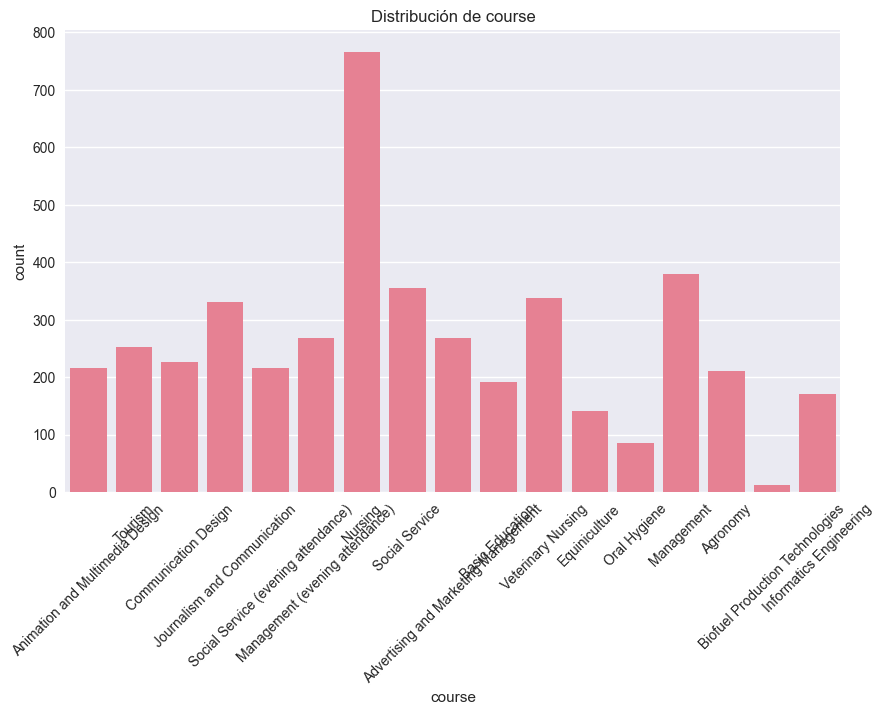

Distribución de course:
                                      count Porcentaje
course                                                
Nursing                                 766     17.31%
Management                              380      8.59%
Social Service                          355      8.02%
Veterinary Nursing                      337      7.62%
Journalism and Communication            331      7.48%
Advertising and Marketing Management    268      6.06%
Management (evening attendance)         268      6.06%
Tourism                                 252       5.7%
Communication Design                    226      5.11%
Animation and Multimedia Design         215      4.86%
Social Service (evening attendance)     215      4.86%
Agronomy                                210      4.75%
Basic Education                         192      4.34%
Informatics Engineering                 170      3.84%
Equiniculture                           141      3.19%
Oral Hygiene                             

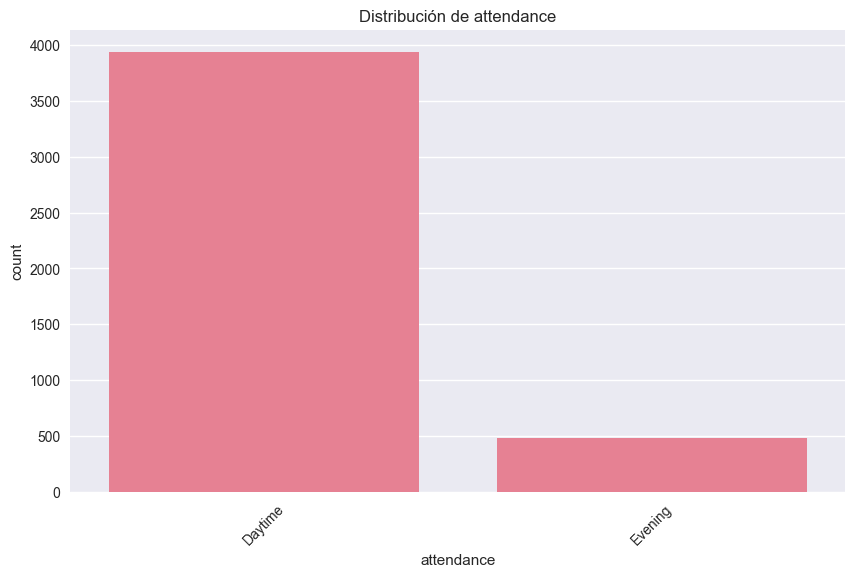

Distribución de attendance:
            count Porcentaje
attendance                  
Daytime      3941     89.08%
Evening       483     10.92%


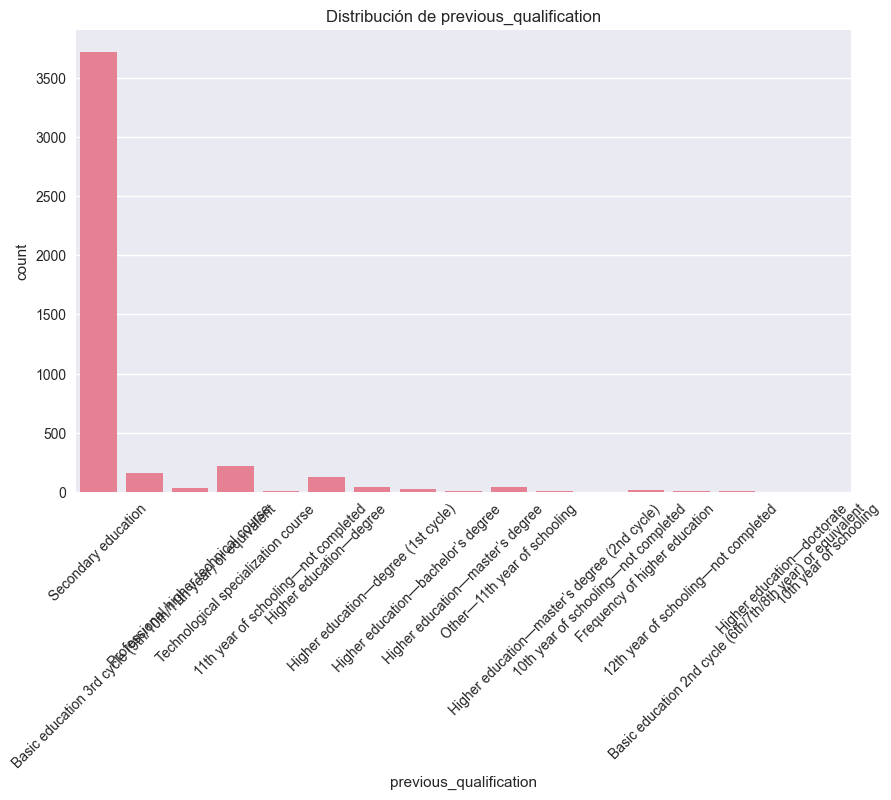

Distribución de previous_qualification:
                                                    count Porcentaje
previous_qualification                                              
Secondary education                                  3717     84.02%
Technological specialization course                   219      4.95%
Basic education 3rd cycle (9th/10th/11th year) ...    162      3.66%
Higher education—degree                               126      2.85%
Other—11th year of schooling                           45      1.02%
Higher education—degree (1st cycle)                    40       0.9%
Professional higher technical course                   36      0.81%
Higher education—bachelor’s degree                     23      0.52%
Frequency of higher education                          16      0.36%
12th year of schooling—not completed                   11      0.25%
Higher education—master’s degree                        8      0.18%
Basic education 2nd cycle (6th/7th/8th year) or...      7      

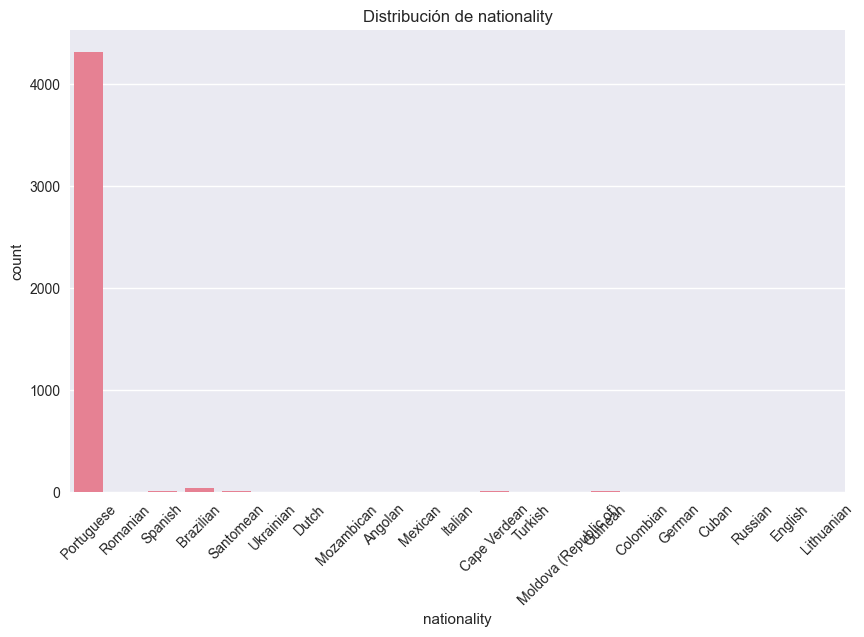

Distribución de nationality:
                       count Porcentaje
nationality                            
Portuguese              4314     97.51%
Brazilian                 38      0.86%
Santomean                 14      0.32%
Spanish                   13      0.29%
Cape Verdean              13      0.29%
Guinean                    5      0.11%
Moldova (Republic of)      3      0.07%
Italian                    3      0.07%
Ukrainian                  3      0.07%
Romanian                   2      0.05%
Angolan                    2      0.05%
Mexican                    2      0.05%
Mozambican                 2      0.05%
German                     2      0.05%
Russian                    2      0.05%
Turkish                    1      0.02%
Dutch                      1      0.02%
Colombian                  1      0.02%
Cuban                      1      0.02%
English                    1      0.02%
Lithuanian                 1      0.02%


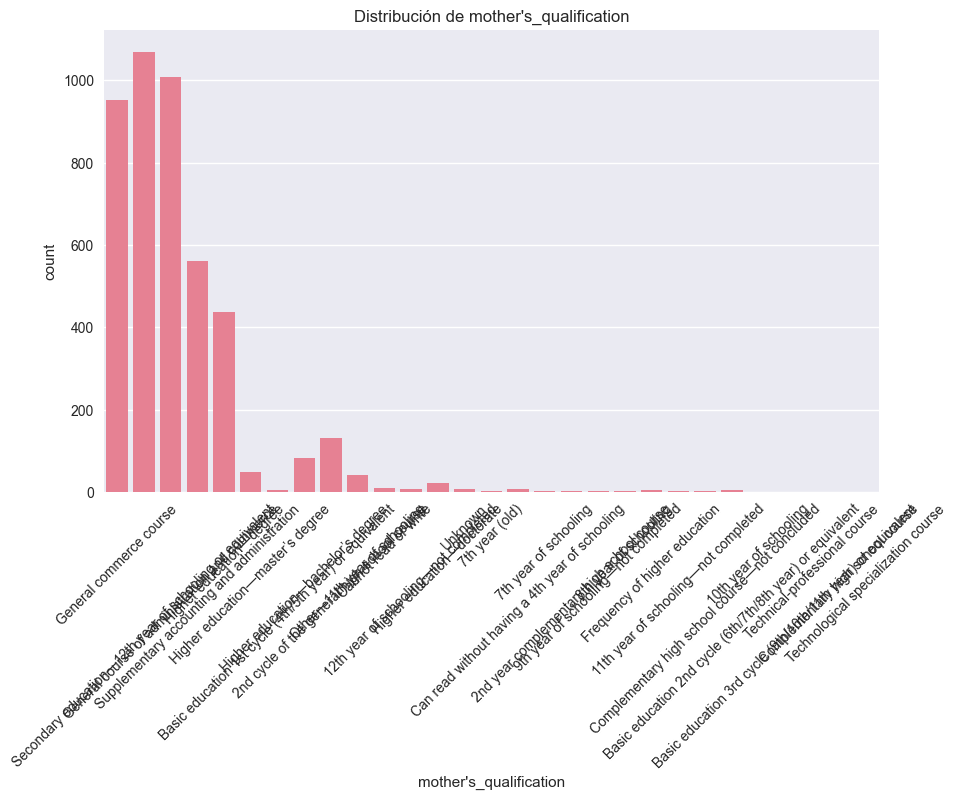

Distribución de mother's_qualification:
                                                    count Porcentaje
mother's_qualification                                              
Secondary education—12th year of schooling or e...   1069     24.16%
General course of administration and commerce        1009     22.81%
General commerce course                               953     21.54%
Supplementary accounting and administration           562      12.7%
Higher education—degree                               438       9.9%
2nd cycle of the general high school course           130      2.94%
Higher education—bachelor’s degree                     83      1.88%
Higher education—master’s degree                       49      1.11%
Other—11th year of schooling                           42      0.95%
Higher education—doctorate                             21      0.47%
Cannot read or write                                    9       0.2%
12th year of schooling—not completed                    8      

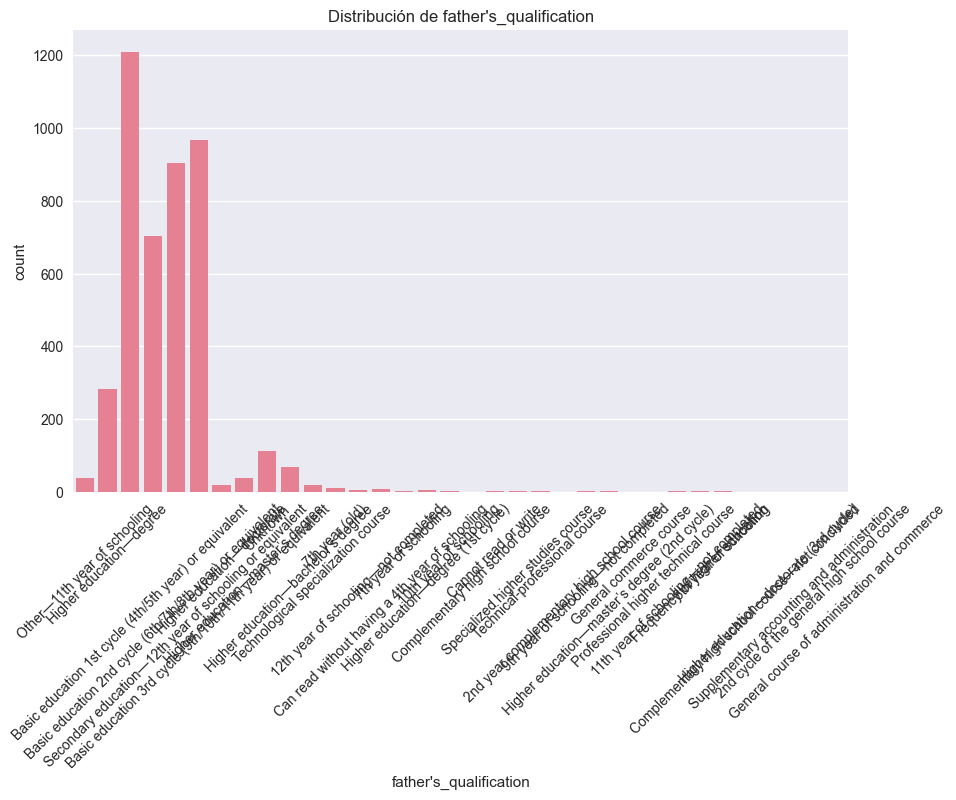

Distribución de father's_qualification:
                                                    count Porcentaje
father's_qualification                                              
Basic education 1st cycle (4th/5th year) or equ...   1209     27.33%
Basic education 3rd cycle (9th/10th/11th year) ...    968     21.88%
Secondary education—12th year of schooling or e...    904     20.43%
Basic education 2nd cycle (6th/7th/8th year) or...    702     15.87%
Higher education—degree                               282      6.37%
Unknown                                               112      2.53%
Higher education—bachelor’s degree                     68      1.54%
Higher education—master’s degree                       39      0.88%
Other—11th year of schooling                           38      0.86%
Technological specialization course                    20      0.45%
Higher education—doctorate                             18      0.41%
7th year (old)                                         10      

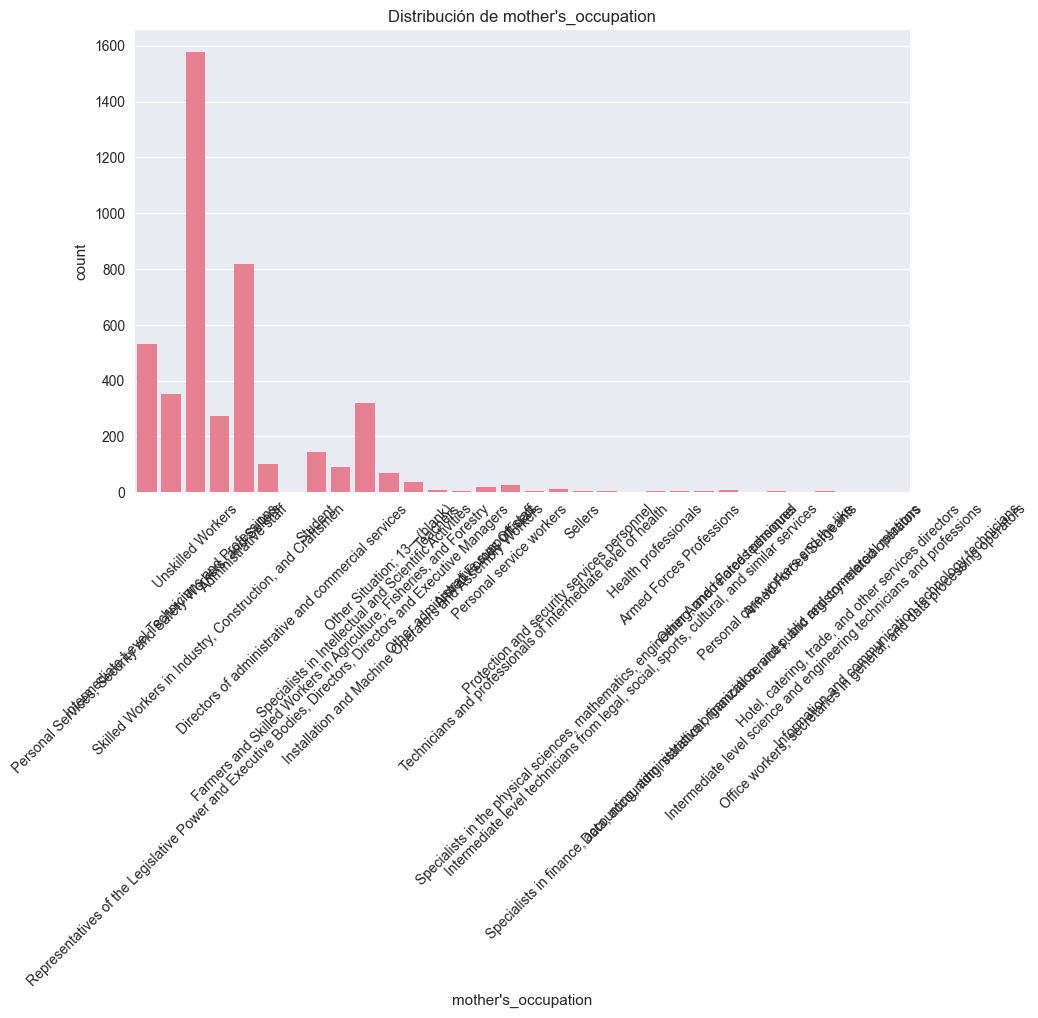

Distribución de mother's_occupation:
                                                    count Porcentaje
mother's_occupation                                                 
Unskilled Workers                                    1577     35.65%
Administrative staff                                  817     18.47%
Personal Services, Security and Safety Workers,...    530     11.98%
Intermediate Level Technicians and Professions        351      7.93%
Specialists in Intellectual and Scientific Acti...    318      7.19%
Skilled Workers in Industry, Construction, and ...    272      6.15%
Student                                               144      3.25%
Representatives of the Legislative Power and Ex...    102      2.31%
Farmers and Skilled Workers in Agriculture, Fis...     91      2.06%
Other Situation; 13—(blank)                            70      1.58%
Installation and Machine Operators and Assembly...     36      0.81%
Personal service workers                               26      0.5

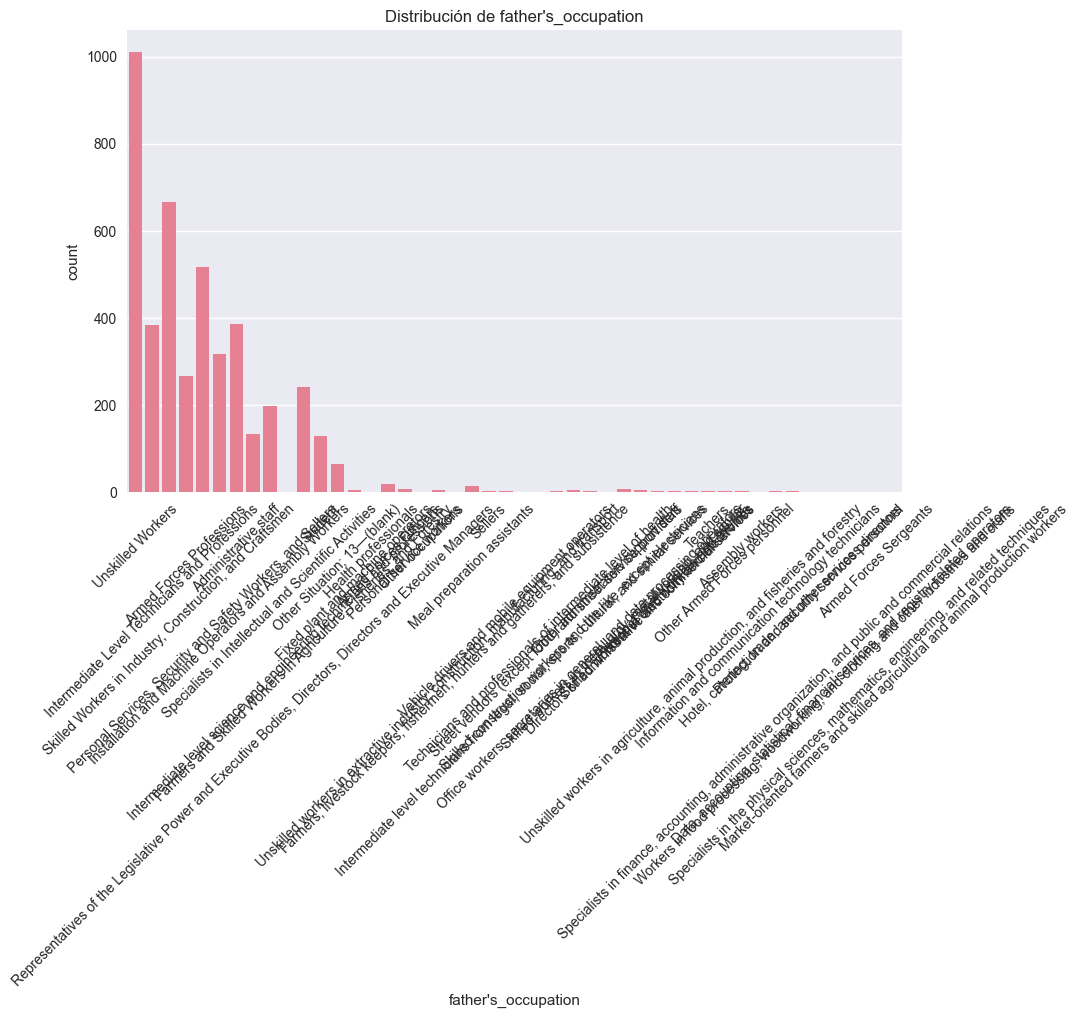

Distribución de father's_occupation:
                                                    count Porcentaje
father's_occupation                                                 
Unskilled Workers                                    1010     22.83%
Skilled Workers in Industry, Construction, and ...    666     15.05%
Personal Services, Security and Safety Workers,...    516     11.66%
Administrative staff                                  386      8.73%
Intermediate Level Technicians and Professions        384      8.68%
Installation and Machine Operators and Assembly...    318      7.19%
Armed Forces Professions                              266      6.01%
Farmers and Skilled Workers in Agriculture, Fis...    242      5.47%
Specialists in Intellectual and Scientific Acti...    197      4.45%
Representatives of the Legislative Power and Ex...    134      3.03%
Student                                               128      2.89%
Other Situation; 13—(blank)                            65      1.4

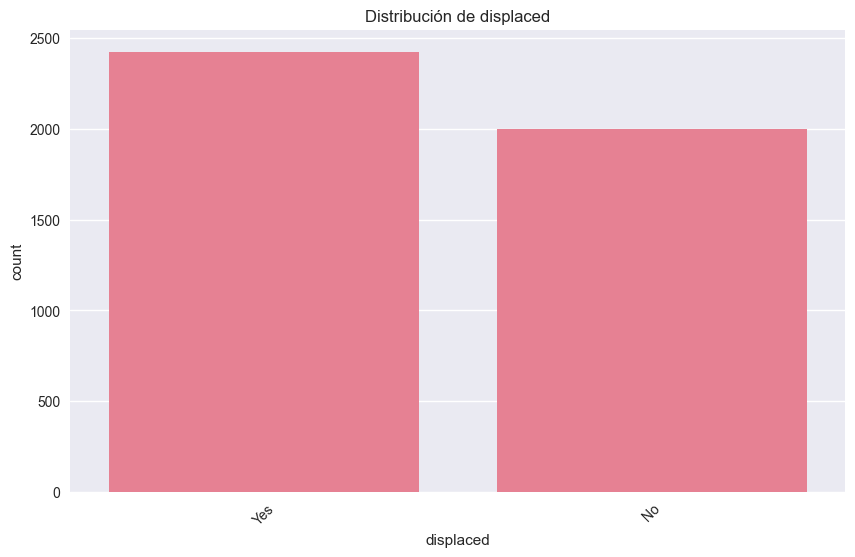

Distribución de displaced:
           count Porcentaje
displaced                  
Yes         2426     54.84%
No          1998     45.16%


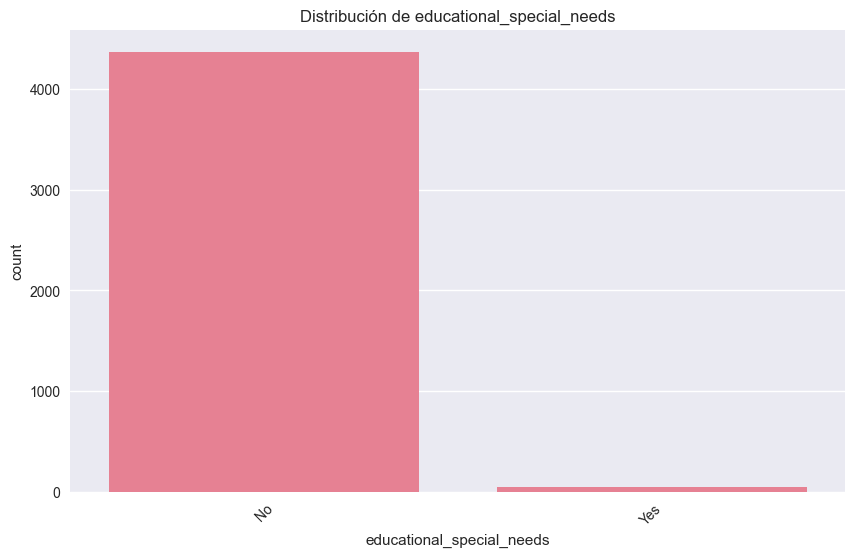

Distribución de educational_special_needs:
                           count Porcentaje
educational_special_needs                  
No                          4373     98.85%
Yes                           51      1.15%


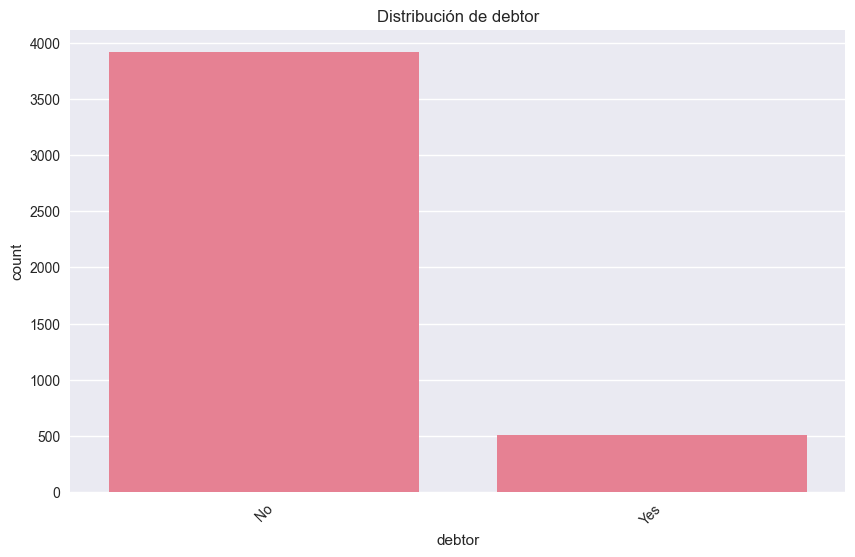

Distribución de debtor:
        count Porcentaje
debtor                  
No       3921     88.63%
Yes       503     11.37%


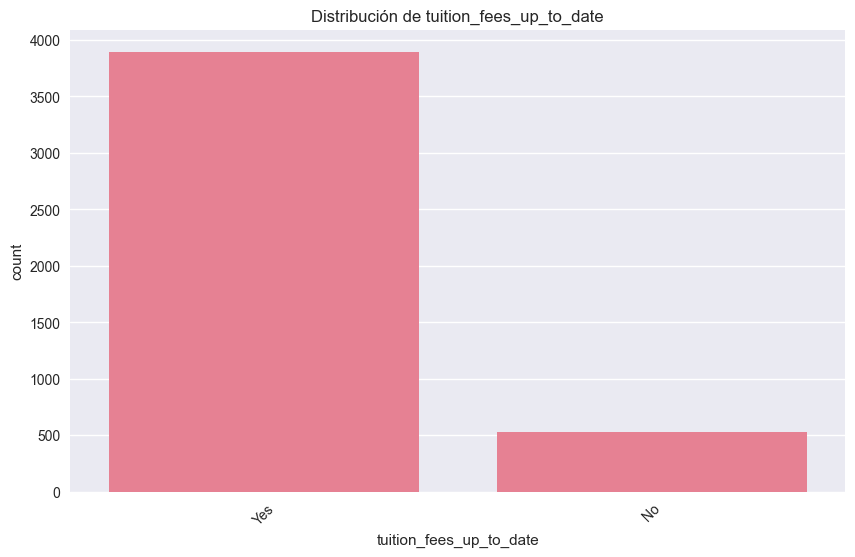

Distribución de tuition_fees_up_to_date:
                         count Porcentaje
tuition_fees_up_to_date                  
Yes                       3896     88.07%
No                         528     11.93%


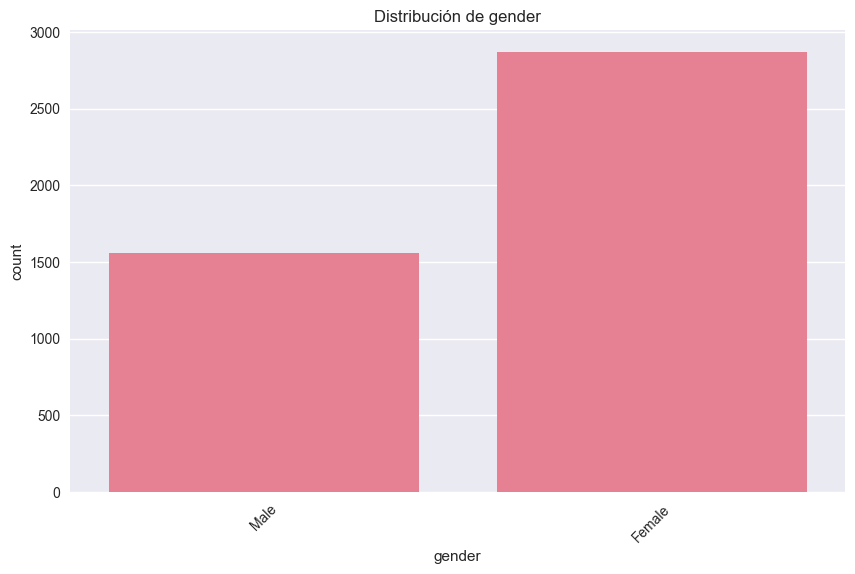

Distribución de gender:
        count Porcentaje
gender                  
Female   2868     64.83%
Male     1556     35.17%


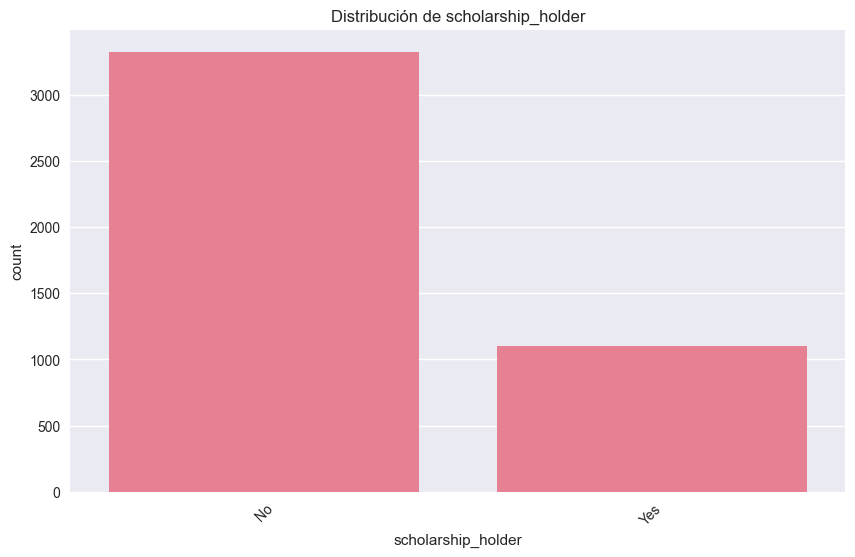

Distribución de scholarship_holder:
                    count Porcentaje
scholarship_holder                  
No                   3325     75.16%
Yes                  1099     24.84%


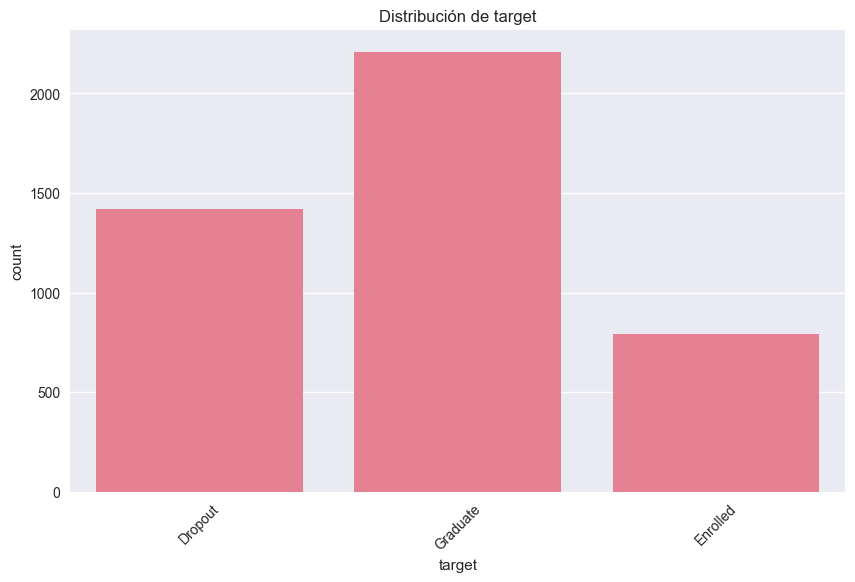

Distribución de target:
          count Porcentaje
target                    
Graduate   2209     49.93%
Dropout    1421     32.12%
Enrolled    794     17.95%


In [53]:
def analisis_categoricas(df):
    categoricas = df.select_dtypes(include=['object']).columns
    
    for col in categoricas:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col)
        plt.title(f'Distribución de {col}')
        plt.xticks(rotation=45)
        plt.show()
        
        # Mostrar frecuencias y porcentajes
        print(f"Distribución de {col}:")
        print(df[col].value_counts().to_frame().join(
            df[col].value_counts(normalize=True).mul(100).round(2).astype(str).add('%').to_frame(
                name='Porcentaje'
            )
        ))

analisis_categoricas(df)

## 8. Análisis Bivariado con Target

Finalmente, analizaremos la relación entre nuestras variables numéricas y la variable objetivo mediante box plots. Esto nos ayudará a identificar qué variables podrían ser más importantes para la clasificación.

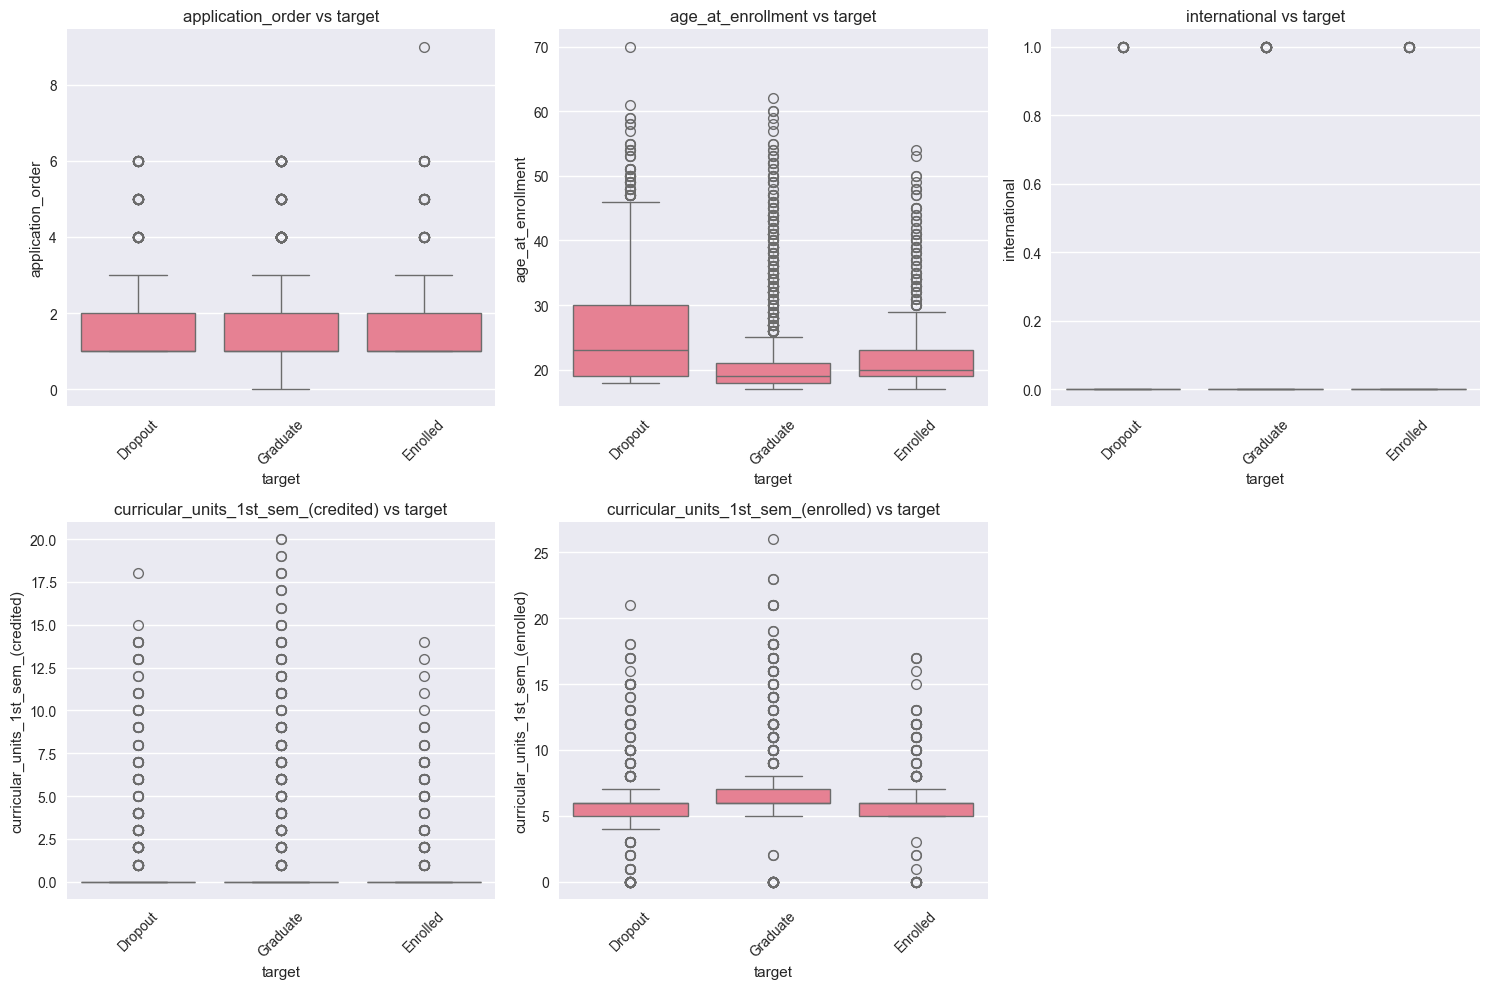

In [54]:
def analisis_bivariado(df):
    numericas = df.select_dtypes(include=['float64', 'int64']).columns[:5]
    
    # Box plots para variables numéricas vs target
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numericas, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(data=df, x='target', y=col)
        plt.title(f'{col} vs target')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

analisis_bivariado(df)

## 9. Análisis de Correlaciones
Finalmente, analizamos las correlaciones entre variables numéricas.

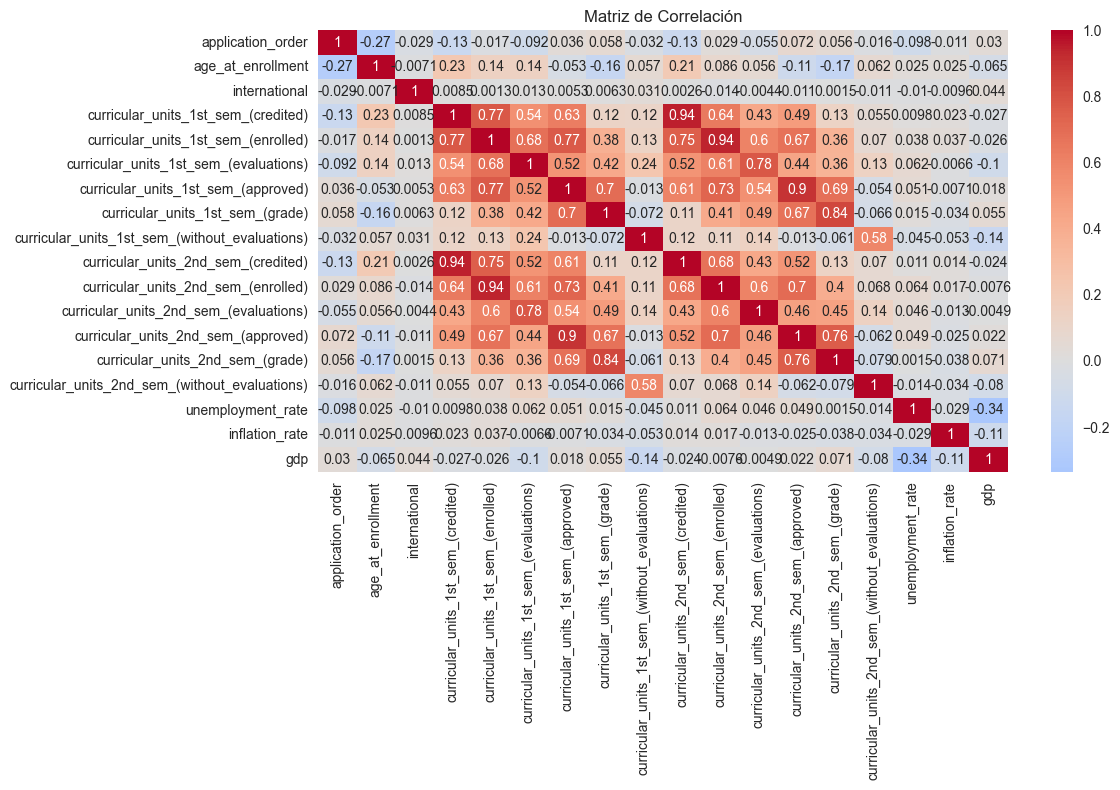

In [55]:
# Crear matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(df_limpio.select_dtypes(include=['float64', 'int64']).corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

## 10. Variables Seleccionadas para Modelado
### Variables Numéricas:
- curricular_units_1st_sem_(grade)
- curricular_units_2nd_sem_(grade)
- curricular_units_1st_sem_(approved)
- curricular_units_2nd_sem_(approved)
- curricular_units_1st_sem_(evaluations)
- curricular_units_2nd_sem_(evaluations)
### Variables Categóricas (One-Hot Encoded):
- scholarship_holder
- tuition_fees_up_to_date
- unemployment_rate
- gdp
- age_at_enrollment
- marital_status
- previous_qualification
- mother's_qualification
- father's_qualification
## 11. Conclusiones del EDA
1. Características del Dataset :

- Contamos con un conjunto de datos balanceado y limpio
- No existen valores nulos que requieran tratamiento
- La base de datos contiene 4,424 registros
- Se tienen 35 variables en total, divididas en:
  - 17 variables categóricas
  - 18 variables numéricas

2. Patrones Identificados :

- Las variables académicas muestran una fuerte correlación con el rendimiento del estudiante
- Los factores socioeconómicos (PIB, tasa de desempleo) tienen una influencia notable
- Existe una relación entre el nivel educativo de los padres y el desempeño académico

3. Variables más Relevantes :

- Académicas :
  - Calificaciones del primer y segundo semestre
  - Número de evaluaciones
  - Unidades curriculares aprobadas
- Socioeconómicas :
  - Estado de la beca
  - Situación de pagos de matrícula
  - Indicadores económicos (PIB, desempleo)
- Demográficas :
  - Edad al matricularse
  - Estado civil
  - Cualificación previa
  - Nivel educativo de los padres

4. Recomendaciones para el Modelado :

- Implementar codificación adecuada para variables categóricas
- Aplicar escalamiento en variables numéricas
- Considerar la creación de características derivadas
- Mantener un equilibrio entre complejidad y capacidad interpretativa del modelo

5. Consideraciones Especiales :

- El dataset está bien estructurado para un problema de clasificación multiclase
- No se requiere un tratamiento extensivo de datos faltantes
- Las variables seleccionadas proporcionan una visión holística del rendimiento estudiantil